In [38]:
import pandas as pd
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [39]:
df = pd.read_csv("BP_data.csv")
df

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


In [40]:
df.drop(columns=['Patient_Number'], inplace=True)

In [41]:
df['Pregnancy'].fillna(0, inplace=True)
df['alcohol_consumption_per_day'].fillna(df['alcohol_consumption_per_day'].median(), inplace=True)
df['Genetic_Pedigree_Coefficient'].fillna(df['Genetic_Pedigree_Coefficient'].mean(), inplace=True)

In [42]:
X = df.drop(columns=['Blood_Pressure_Abnormality']).values
y = df['Blood_Pressure_Abnormality'].values.reshape(-1, 1)

In [43]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
class BPClassifier(nn.Module):
    def __init__(self, input_size):
        super(BPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        return self.model(x)

model = BPClassifier(input_size=X.shape[1])
model

BPClassifier(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [46]:
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [47]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=10):
    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    val_losses = []

    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X).squeeze()
            loss = criterion(output, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                output = model(val_X).squeeze()
                loss = criterion(output, val_y.squeeze())
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

In [48]:
model = BPClassifier(input_size=X.shape[1])
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

trained_model, train_loss_hist, val_loss_hist = train_model(
    model, train_loader, val_loader, criterion, optimizer
)

Epoch 1: Train Loss = 0.6544, Val Loss = 0.5945
Epoch 2: Train Loss = 0.5509, Val Loss = 0.5074
Epoch 3: Train Loss = 0.5071, Val Loss = 0.4832
Epoch 4: Train Loss = 0.4753, Val Loss = 0.4511
Epoch 5: Train Loss = 0.4489, Val Loss = 0.4274
Epoch 6: Train Loss = 0.4326, Val Loss = 0.4042
Epoch 7: Train Loss = 0.4186, Val Loss = 0.3924
Epoch 8: Train Loss = 0.3890, Val Loss = 0.3825
Epoch 9: Train Loss = 0.3991, Val Loss = 0.3768
Epoch 10: Train Loss = 0.3966, Val Loss = 0.3718
Epoch 11: Train Loss = 0.3698, Val Loss = 0.3698
Epoch 12: Train Loss = 0.3861, Val Loss = 0.3736
Epoch 13: Train Loss = 0.3636, Val Loss = 0.3594
Epoch 14: Train Loss = 0.3866, Val Loss = 0.3562
Epoch 15: Train Loss = 0.3537, Val Loss = 0.3555
Epoch 16: Train Loss = 0.3222, Val Loss = 0.3526
Epoch 17: Train Loss = 0.3510, Val Loss = 0.3581
Epoch 18: Train Loss = 0.3738, Val Loss = 0.3669
Epoch 19: Train Loss = 0.3498, Val Loss = 0.3692
Epoch 20: Train Loss = 0.3585, Val Loss = 0.3662
Epoch 21: Train Loss = 0.3393

Accuracy: 0.855
F1 Score: 0.8489583333333335
[[179  24]
 [ 34 163]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       203
           1       0.87      0.83      0.85       197

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



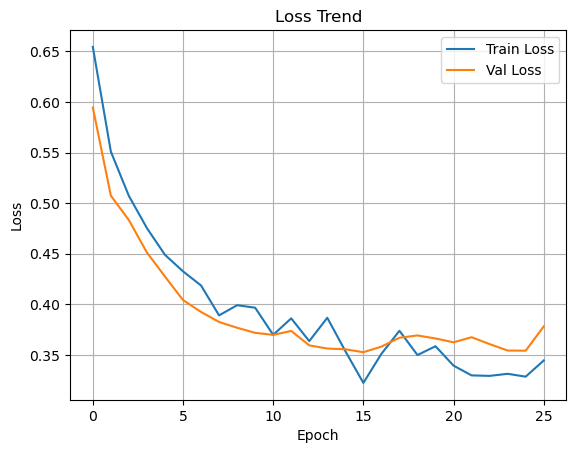

In [49]:


trained_model.eval()
with torch.no_grad():
    y_pred_prob = trained_model(X_test_tensor).squeeze().numpy()
    y_pred = (y_pred_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.grid(True)
plt.show()